In [1]:
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from keras.utils import np_utils
from keras.models import load_model
from keras.datasets import cifar10
from keras.preprocessing import image
from tqdm import tqdm
from PIL import Image
import tensorflow.keras as keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pandas as pd

Using TensorFlow backend.


# of occurences
[ 4522 12875  3323   867  2624   239   253   628]
Classes
[0 1 2 3 4 5 6 7]


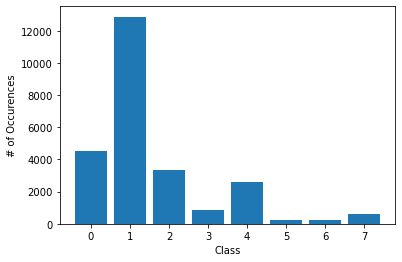

In [2]:
gnd_truth = pd.read_csv("data\SkinDiseaseDataset\ISIC_2019_Training_GroundTruth.csv")
#aug_df = pd.read_csv("data/augmentImageNameLabels.csv")
gnd_truth.head()

IMG_NAMES = gnd_truth['image']
TRAIN_IMG_RT_PATH = 'data/ISIC_2019_Training_Input/'
TEST_IMG_RT_PATH = 'data/ISIC_2019_Test_Input'
### No Examples of UNK so drop it
labels = np.array(gnd_truth.drop(columns = ["image", "UNK"]))

c, freq = np.unique(np.argmax(labels, axis= 1), return_counts = True)
plt.xlabel("Class")
plt.ylabel("# of Occurences")
plt.bar(c,freq)
print("# of occurences")
print(freq)
print("Classes")
print(c)

In [10]:
def returnClassIndex(trainY,class_index):
    labels = np.argmax(trainY, axis = 1)
    return [ i for i in range(len(labels)) if labels[i] == class_index]

def creatModelInstance(output):
    print("Creating Model....")
    conv_base = ResNet50(weights='imagenet', include_top=False, input_shape=(200, 200, 3))
    model = models.Sequential()
    #model.add(layers.UpSampling2D((2,2)))
    #model.add(layers.UpSampling2D((2,2)))
    #model.add(layers.UpSampling2D((2,2)))
    model.add(conv_base)
    model.add(layers.Flatten())
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.BatchNormalization())
    model.add(layers.Dense(output, activation='softmax'))
    model.summary()
    return model 

In [11]:
### Randomly Balance Sample from classes  
smpl_test_idxs = []
smpl_train_idxs = []
for i in range(len(labels[1])):
    idxs = np.array(returnClassIndex(labels, i))
    sel = np.random.RandomState(seed = 42).permutation(len(idxs))
    #print(len(idxs))
    ### Shuffle
    train_sel = list(sel[:int(0.75*len(idxs))])
    test_sel = list(sel[int(0.75*len(idxs)):])
    smpl_train_idxs += list(idxs[train_sel])
    smpl_test_idxs += list(idxs[test_sel])

paths = np.array([TRAIN_IMG_RT_PATH + m +'.jpg' for m in IMG_NAMES ])

In [177]:
### Selecting the classes
hold_in_train_class = [0,1,2,3]
hold_in_train_class_idx = []
for i in hold_in_train_class:
    if(i == 1):
        hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(labels[smpl_train_idxs],
                                                                             i)[:5000]
    else:
         hold_in_train_class_idx = hold_in_train_class_idx + returnClassIndex(labels[smpl_train_idxs],
                                                                             i)
### Selecting the classes
hold_in_test_class = [0,1,2,3]
hold_in_test_class_idx = []
for i in hold_in_test_class:
    hold_in_test_class_idx = hold_in_test_class_idx + returnClassIndex(labels[smpl_test_idxs],i)

testY0 = keras.utils.to_categorical(np.argmax(labels[smpl_test_idxs][hold_in_test_class_idx],
                                              axis =1), num_classes = 4
                                   )
trainY0 = keras.utils.to_categorical(np.argmax(labels[smpl_train_idxs][hold_in_train_class_idx]
                                               , axis =1), num_classes = 4
                                    )

paths_trainX0 = paths[smpl_train_idxs][hold_in_train_class_idx]
paths_testX0 = paths[smpl_test_idxs][hold_in_test_class_idx]

In [74]:
im_size =200
channels = 3
num_classes = 2
lr = 0.001 ### learning rate
input_shape = ( im_size, im_size, channels)
l1_lambda = 0 ### L1 regularization lambda parameter
l2_lambda = 0
keep_prob =  0
batch_size = 4

In [178]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths_trainX0.ravel(),
                        "class": np.argmax(trainY0,axis =1 ).astype(str)})
test_df = pd.DataFrame({"filename":paths_testX0.ravel(),
                        "class": np.argmax(testY0,axis =1 ).astype(str)})

train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
batch_size = 4
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size),
    shuffle = False
)
test_generator = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size),
    shuffle = False
)

Found 11533 validated image filenames belonging to 4 classes.
Found 5398 validated image filenames belonging to 4 classes.


In [15]:
model0 = creatModelInstance(4)

Creating Model....
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_1 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_3 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 128)               512       
_________________________________________________________________
dense_4 (Dense)              (None,

In [ ]:

model0.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', 
              metrics=['acc'])
history = model0.fit(train_generator,
                    epochs=10,verbose = True,
                     validation_data = test_generator
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 2884 steps, validate for 1350 steps
Epoch 1/10
2884/2884 [==============================] - 543s 188ms/step - loss: 1.2200 - acc: 0.4335 - val_loss: 1.0951 - val_acc: 0.5963
Epoch 2/10
2883/2884 [============================>.] - ETA: 0s - loss: 1.2194 - acc: 0.4333

In [ ]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(3)+1,history.history['loss'])

## Fine tunning Model

In [ ]:
history1 = model0.fit(trainX[hold_in_train_class_idx],trainY0,
                     batch_size=batch_size, epochs=3,
                     validation_data = (testX[hold_in_test_class_idx],
                                                        testY0),
                    )

In [ ]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(6)+1,list(history.history['loss'])+ list(history1.history['loss']))

In [21]:
print("Evaluating model on Old classes")
scores = model0.evaluate(test_generator)

Evaluating model on Old classes
  ...
    to  
  ['...']
338/338 [==============================] - 78s 230ms/step - loss: 0.4561 - acc: 0.7982


In [26]:
labels[smpl_test_idxs][hold_in_test_class_idx1]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]])

In [61]:
print("Evalauting model on new classes")
scores_new = model0.evaluate(test_generator1)
print("Note performace")

Evalauting model on new classes
  ...
    to  
  ['...']
59/59 [==============================] - 12s 203ms/step - loss: 0.7955 - acc: 0.5320
Note performace


In [66]:
print("Loading in New class detector...")
with open('Models/skin_disease_resnet_No_AUG_88acc.json', 'r') as j_file:
    loaded_model_json = j_file.read()
newclass_detector = tf.keras.models.model_from_json(loaded_model_json)
newclass_detector.load_weights("Models/skin_disease_resnet_No_AUG_88acc.h5")
newclass_detector.compile(optimizer=tf.keras.optimizers.RMSprop(lr=2e-5), 
                         loss='binary_crossentropy',metrics=['acc']
                        )
                         
print("Done!")

Loading in New class detector...
Done!


In [77]:
train_df2 = pd.DataFrame({"filename":paths[smpl_train_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_train_idxs].astype(str)})
test_df2 = pd.DataFrame({"filename":paths[smpl_test_idxs],
                        "class": np.argmax(labels, axis = 1)[smpl_test_idxs].astype(str)})

train_datagen2 = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
test_datagen2 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator2 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size)
)
test_generator2 = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size),
    shuffle = False
)

Found 16189 validated image filenames belonging to 4 classes.
Found 5398 validated image filenames belonging to 4 classes.


In [78]:
print("Detecting New classes") 
print("0 - indicates a unknown classs ")
print("1 - Indicates a Known class")
results = newclass_detector.predict(test_generator2, verbose = 1)
print("Done!")

Detecting New classes
0 - indicates a unknown classs 
1 - Indicates a Known class
338/338 [==============================] - 47s 139ms/step
Done!


In [86]:
print("Extracting new classes from DataStream")
results_ = np.argmax(results.round(), axis = 1)
lst = [4,5,6,7]
new_classes = []
for i in lst:
    new_classes = new_classes + returnClassIndex(results, i)
print("Number of new classes is ", len(new_classes))
print("Done!")

Extracting new classes from DataStream
Number of new classes is  18
Done!


"Number of new classes is  18"=> noted
switching to manually assigning the new classes to new instance

## Creating New Model Instance

In [59]:
### Selecting the classes
hold_in_train_class1 = [4,5,6,7]
hold_in_train_class_idx1 = []
for i in hold_in_train_class1:
    hold_in_train_class_idx1 = hold_in_train_class_idx1 + returnClassIndex(labels[smpl_train_idxs],i)
### Selecting the classes
hold_in_test_class1 = [4,5,6,7]
hold_in_test_class_idx1 = []
for i in hold_in_test_class1:
    hold_in_test_class_idx1 = hold_in_test_class_idx1 + returnClassIndex(labels[smpl_test_idxs],i)

testY1 = keras.utils.to_categorical(np.argmax(labels[smpl_test_idxs][hold_in_test_class_idx1],
                                              axis =1)-4, num_classes = 4
                                   )
trainY1 = keras.utils.to_categorical(np.argmax(labels[smpl_train_idxs][hold_in_train_class_idx1]
                                               , axis =1)-4, num_classes = 4
                                    )

paths_trainX1 = paths[smpl_train_idxs][hold_in_train_class_idx1]
paths_testX1 = paths[smpl_test_idxs][hold_in_test_class_idx1]

In [154]:
### Dataframes for Generator
train_df = pd.DataFrame({"filename":paths_trainX1.ravel(),
                        "class": np.argmax(trainY1,axis =1 ).astype(str)})
test_df = pd.DataFrame({"filename":paths_testX1.ravel(),
                        "class": np.argmax(testY1,axis =1 ).astype(str)})

train_datagen1 = tf.keras.preprocessing.image.ImageDataGenerator(
        rescale=1.0/255,
        samplewise_center = True,
        samplewise_std_normalization = True, 
        horizontal_flip=True,
        vertical_flip = True,
        shear_range=0.5,
        zoom_range=0.5,
        rotation_range = 30
)
batch_size = 25
test_datagen1 = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
train_generator1 = train_datagen.flow_from_dataframe(
    dataframe = train_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size, 
    target_size = (im_size, im_size),
    shuffle = True
)
test_generator1 = test_datagen.flow_from_dataframe(
    dataframe = test_df,
    class_mode = 'categorical',
    y_col="class",
    batch_size = batch_size,
    target_size = (im_size, im_size),
    shuffle = False
)

Found 2807 validated image filenames belonging to 4 classes.
Found 937 validated image filenames belonging to 4 classes.


In [87]:
model1 = creatModelInstance(4)

Creating Model....
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 7, 7, 2048)        23587712  
_________________________________________________________________
flatten_2 (Flatten)          (None, 100352)            0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 100352)            401408    
_________________________________________________________________
dense_6 (Dense)              (None, 128)               12845184  
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 128)               512       
_________________________________________________________________
dense_7 (Dense)              (None,

In [155]:

model1.compile(optimizer=optimizers.Adam(0.001), loss='categorical_crossentropy', 
              metrics=['acc'])
history1 = model1.fit(train_generator1, epochs=20, verbose = 1,
                     validation_data = test_generator1
                    )

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 113 steps, validate for 38 steps
Epoch 1/20
113/113 [==============================] - 208s 2s/step - loss: 0.9275 - acc: 0.7000 - val_loss: 0.9246 - val_acc: 0.7001
Epoch 2/20
113/113 [==============================] - 184s 2s/step - loss: 0.9152 - acc: 0.6997 - val_loss: 0.9338 - val_acc: 0.7001
Epoch 3/20
 76/113 [===================>..........] - ETA: 53s - loss: 0.9256 - acc: 0.6871

KeyboardInterrupt: 

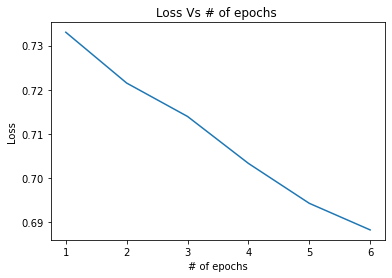

In [90]:
plt.title("Loss Vs # of epochs ")
plt.xlabel("# of epochs")
plt.ylabel("Loss")
plt.plot(np.arange(6)+1,history1.history['loss'])

In [102]:
tmp = next(test_generator1)

In [104]:
tmp[1].shape

(16, 4)

In [156]:
testY = []
pred = []
for i in tqdm(range(len(test_generator1))):
    tmp = next(test_generator1)
    pred.append(model1.predict(tmp[0]))
    testY.append(tmp[1])

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:38<00:00,  1.02s/it]


In [157]:
results1= np.vstack(pred)
testY__ = np.vstack(testY)

In [158]:
tmp[0].shape

(12, 200, 200, 3)

In [159]:
print("Performing predictions...")
"""
print("Extracting indexes Misclassified prediction due model integration")
tmp = np.argmax(testY[c], axis = 1)
d = [i for i in range(len(tmp)) if (tmp[i] >=5)]
print("A {}% error is introduced as a consequcent of cacding the models".
      format(round(((len(tmp)-len(d))/len(tmp) *100), 3)))

testY__ = tf.keras.utils.to_categorical(
    np.clip(np.absolute(np.argmax(testY[c], axis = 1)-5), 0,4))
"""
print("Evaluating model on new class!")
scores1 = model1.evaluate(test_generator1)
print("Done!")

Performing predictions...
Evaluating model on new class!
  ...
    to  
  ['...']
38/38 [==============================] - 21s 546ms/step - loss: 0.9228 - acc: 0.7001
Done!


In [160]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score 
from sklearn.metrics import recall_score, precision_score
p1_= np.argmax(results1, axis =1 ) 
t1_=  np.argmax(testY__, axis = 1)
acc1 = accuracy_score(t1_, p1_)
f1_1 = f1_score(t1_, p1_, average = "macro")
recall_1 = recall_score(t1_, p1_,   average = "macro")
precision_1 =precision_score(t1_, p1_, average = "macro")


#print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc1))
print("F1 Score: {}".format(f1_1))
print("recall Score: {}".format(recall_1))
print("Precision Score: {}".format(precision_1))

Accuracy: 0.7001067235859125
F1 Score: 0.2059008160703076
recall Score: 0.25
Precision Score: 0.17502668089647813


c:\users\user\anaconda3\envs\myenv\lib\site-packages\sklearn\metrics\_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [166]:
gnd_truth.columns[-4:]

Index(['DF', 'VASC', 'SCC', 'UNK'], dtype='object')

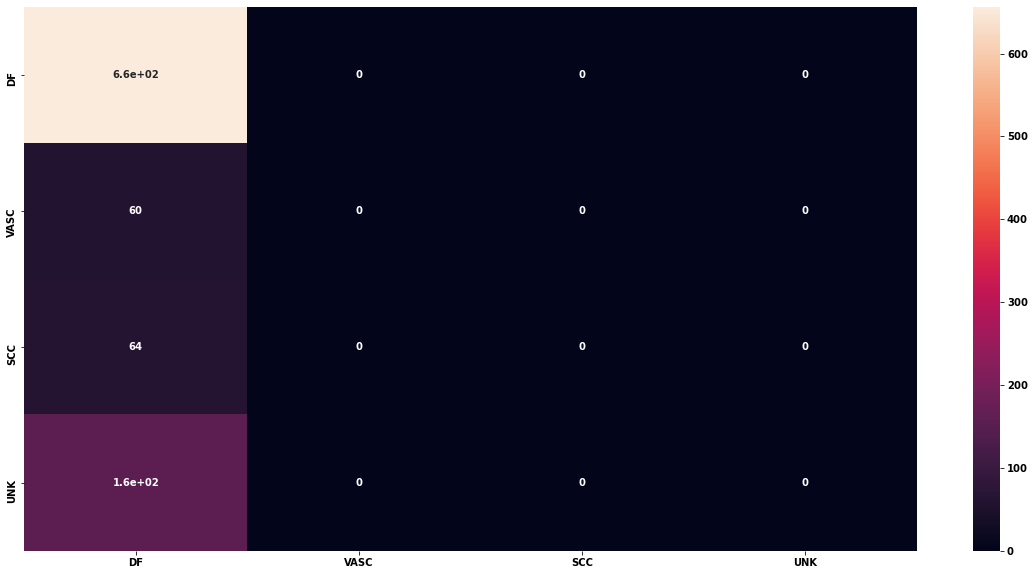

In [167]:
import matplotlib
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf = tf.math.confusion_matrix(t1_,p1_)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = gnd_truth.columns[-4:]
df_cm = pd.DataFrame(np.array(conf), index = labels_names,
                  columns =  labels_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [170]:
p1_.shape

(937,)

c:\users\user\anaconda3\envs\myenv\lib\site-packages\ipykernel_launcher.py:35: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead


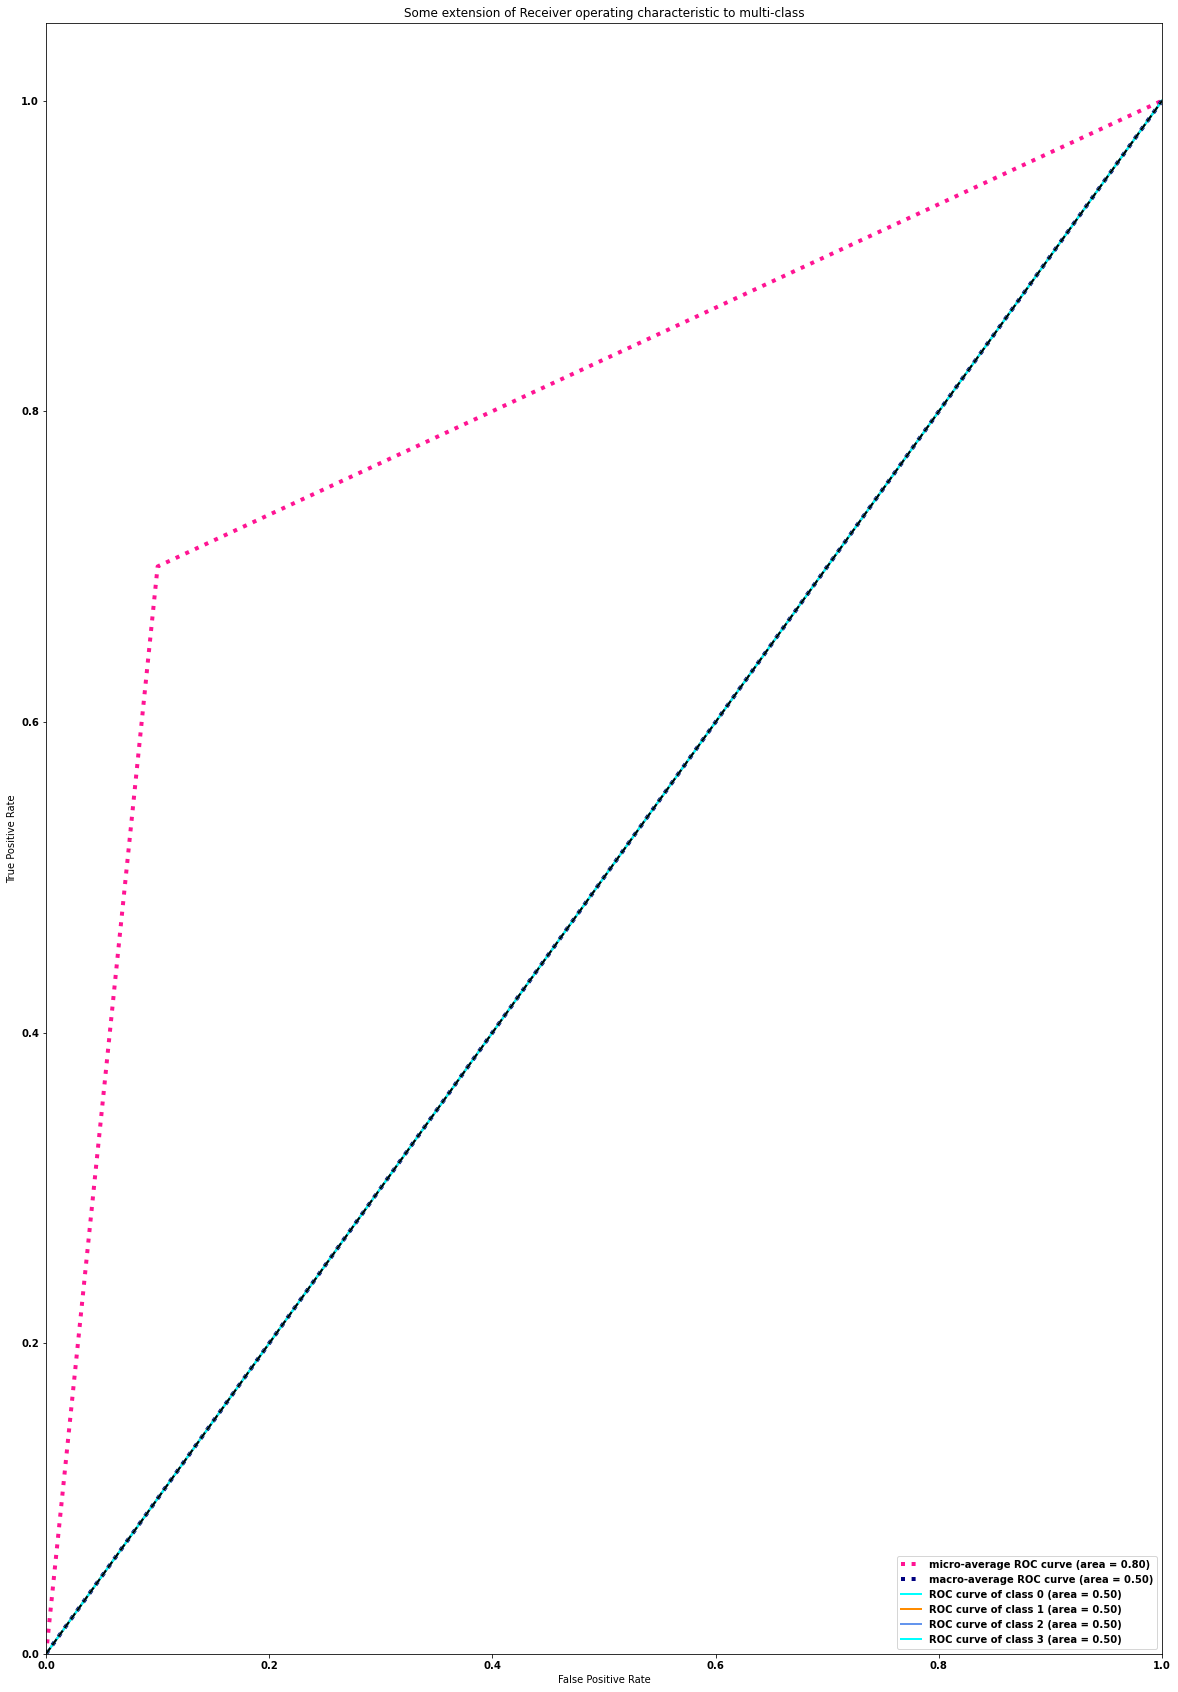

In [171]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(t1_, num_classes =4))
y_score = np.copy(tf.keras.utils.to_categorical(p1_, num_classes =4))
n_classes =  4
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [172]:
## Known class
c1 = [i for i in range(len(results)) if(results_[i] == 1)]
tmp0 = np.argmax(testY[c1], axis = 1)
print("Performing predictions...")
results0 = model0.predict(testX[c1], verbose = 1)
print("Extracting indexes Misclassified prediction due model integration")
d0 = [i for i in range(len(tmp0)) if (tmp0[i] >=5)]
print("A {}% error is introduced as a consequcent of cascading the models".
      format(round(((len(d0))/len(tmp0) *100), 3)))
tmp0[d0] = 4
testY0__ = tf.keras.utils.to_categorical(tmp0)
print("Evaluating model on new class!")
scores1 = model0.evaluate(testX[c1],testY0__, verbose = 1)
print("Done!")

TypeError: list indices must be integers or slices, not list

In [ ]:
from sklearn.metrics import accuracy_score, log_loss, roc_curve, f1_score 
from sklearn.metrics import recall_score, precision_score
print("Evaluating model on new class!")
p0_= np.argmax(results0, axis =1 ) 
t0_=  np.argmax(testY0__, axis = 1)
acc0 = accuracy_score(t0_, p0_)
f1_0 = f1_score(t0_, p0_, average = "macro")
recall_0 = recall_score(t0_, p0_,   average = "macro")
precision_0 =precision_score(t0_, p0_, average = "macro")

loss = log_loss( np.copy(tf.keras.utils.to_categorical(t0_)),
                np.copy(tf.keras.utils.to_categorical(p0_)))
print("Loss: {}".format(loss))
print("Accuracy: {}".format(acc0))
print("F1 Score: {}".format(f1_0))
print("recall Score: {}".format(recall_0))
print("Precision Score: {}".format(precision_0))
print("Done!")

In [ ]:
import matplotlib
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt

conf = tf.math.confusion_matrix(t0_,p0_)
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 10}
matplotlib.rc('font', **font)
labels_names = ['airplane','automobile','bird','cat','deer']
df_cm = pd.DataFrame(np.array(conf), index = labels_names,
                  columns =  labels_names)
plt.figure(figsize = (20,10))
sn.heatmap(df_cm, annot=True)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import cycle

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
y_test = np.copy(tf.keras.utils.to_categorical(t0_))
y_score = np.copy(tf.keras.utils.to_categorical(p0_))
n_classes =  5
lw =2
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_score.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])



# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize = (20, 30))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Some extension of Receiver operating characteristic to multi-class')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model0, to_file='known_classes_model_instance.png')

# Serialize model to JSON
model_json = model0.to_json()
with open("Models/known_classes_model_instance.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model1.save_weights("Models/known_classes_model_instance.h5")
print("Saved model to disk")

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model1, to_file='skin_known_classes_model_instance.png')

# Serialize model to JSON
model_json = model1.to_json()
with open("Models/skin_unknown_classes_model_instance.json", "w") as json_file:
    json_file.write(model_json)
# Serialize weights to HDF5
model1.save_weights("Models/skin_unknown_classes_model_instance.h5")
print("Saved model to disk")